# Using the model to estimate to whole panicle

## Cropping the images to 3 patches

### Libraries

In [1]:
import numpy as np
import cv2 
import os
import json
import matplotlib.pyplot as plt

### Cropping Images

In [ ]:
# Path to your input folder containing JSON files and images
input_folder = "./../Data/counted_sorghum_panicles"
output_folder = "./counted_images"

os.makedirs(output_folder, exist_ok=True)

# Define the target image size
target_size = (224, 224)

# Iterate through the images and JSON files
for image_file in os.listdir(input_folder):
    if image_file.endswith(".jpg"):
        # Load the image
        image = cv2.imread(os.path.join(input_folder, image_file))

    json_file = os.path.join(input_folder, os.path.splitext(image_file)[0] + ".json")
    # Load points from JSON file
    with open(json_file, 'r') as file:
        data = json.load(file)
        points = data["shapes"][0]['points']

    mask = np.zeros(image.shape[0:2], dtype=np.uint8)
    pontos = np.array([points])
    pontos = pontos.astype(int)
    cv2.fillPoly(mask, pontos, (255))
    res = cv2.bitwise_and(image,image,mask = mask)

    tmp = cv2.cvtColor(res, cv2.COLOR_BGR2GRAY)
    _, alpha = cv2.threshold(tmp, 0, 255, cv2.THRESH_BINARY)
    b, g, r = cv2.split(res)
    rgba = [b, g, r, alpha]
    dst = cv2.merge(rgba, 4)

    x_array = []
    y_array = []

    # Generate density maps based on annotations
    for point in points:
        x, y = point
        x, y = int(x), int(y)
        x_array.append(x)
        y_array.append(y)

    x_max = max(x_array)
    x_min = min(x_array)
    y_max = max(y_array)
    y_min = min(y_array)

    centered_image = dst[y_min:y_max, x_min:x_max]

    height, width = centered_image.shape[:2]
    crop_height = height // 3

    for i in range(3):
            # Calculate the coordinates for cropping
            y1 = i * crop_height
            y2 = (i + 1) * crop_height

            # Crop the region
            cropped_image = centered_image[y1:y2, :]

            # Define the output file name for each cropped image
            cropedImageName = os.path.splitext(image_file)[0]+'.png'
            output_filename = os.path.join(output_folder, f"{i}_{cropedImageName}")

            # Save the cropped image
            cv2.imwrite(output_filename, cropped_image)

    print("Cropping", image_file)

print("Cropping finished")

## Using the model to estimate counting

### Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, UpSampling2D, BatchNormalization, Activation, Concatenate, ZeroPadding2D, AveragePooling2D
from tensorflow.keras.models import Model 

import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

import csv

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

### Defining Model

In [4]:
def Sorghum_Net(input_shape):
    
    input_tensor = Input(shape=input_shape)
    
    # Up
    x = Conv2D(80, (3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(160, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2))(x)

    x = Conv2D(80, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(40, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Middle
    y = Conv2D(40, (5, 5), padding='same')(input_tensor)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = MaxPooling2D((2, 2), strides=(2, 2))(y)

    y = Conv2D(80, (5, 5), padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    y = MaxPooling2D((2, 2), strides=(2, 2))(y)

    y = Conv2D(40, (5, 5), padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    
    y = Conv2D(20, (5, 5), padding='same')(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)

    # Down
    z = Conv2D(20, (7, 7), padding='same')(input_tensor)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)
    z = MaxPooling2D((2, 2), strides=(2, 2))(z)

    z = Conv2D(40, (7, 7), padding='same')(z)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)
    z = MaxPooling2D((2, 2), strides=(2, 2))(z)

    z = Conv2D(20, (7, 7), padding='same')(z)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)
    
    z = Conv2D(40, (7, 7), padding='same')(z)
    z = BatchNormalization()(z)
    z = Activation('relu')(z)

    # Concatenate the feature maps
    concatenated = Concatenate()([x, y, z])

    # Upsample feature maps
    upsampled = UpSampling2D(size=(4, 4))(concatenated)
    output = Conv2D(2, (1, 1), padding='same')(upsampled)
    
    # Create the model
    model = Model(inputs=input_tensor, outputs=output)
    
    return model

input_shape = (224, 224, 3)

model = Sorghum_Net(input_shape)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_13 (Conv2D)             (None, 224, 224, 80  2240        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_17 (Conv2D)             (None, 224, 224, 40  3040        ['input_2[0][0]']                
                                )                                                           

In [5]:
input_shape = (224, 224, 3)

inference_model = Sorghum_Net(input_shape)

inference_model.load_weights('./weights/Sorghum_Net_weights.h5')

### Counting and saving into a csv with the ground truth

In [ ]:
temporary_prediction = []
prediction_array = []

input_folder = "./counted_images/"

basename_sums = {}

for file_basename in os.listdir(input_folder):

    x_image_path = os.path.join(input_folder, file_basename)

    basename = x_image_path.split('_')[2].split('.')[0]

    image_width, image_height = 224, 224
    new_image = load_img(x_image_path, target_size=(image_width, image_height))
    new_image_array = img_to_array(new_image)
    new_image_array = np.array(new_image_array, dtype=np.float32)

    predictions = inference_model.predict(np.expand_dims(new_image_array, axis=0))
    probability_map = predictions[0, :, :, 0]
    predicted = np.sum(probability_map)/(255*25)

    if basename not in basename_sums:
        basename_sums[basename] = predicted
    else:
        basename_sums[basename] += predicted

csv_filename = "estimated_counting.csv"

with open(csv_filename, mode='w', newline='') as csv_file:
    fieldnames = ['id', 'estimated']
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)

    writer.writeheader()
    for basename, sum_value in basename_sums.items():
        writer.writerow({'id': basename, 'estimated': sum_value})

print(f"CSV file '{csv_filename}' has been created.")

## Comparing the two pictures from the same panicle

### Libraries

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

### Comparing

In [8]:
df = pd.read_csv('./estimated_counting.csv')

df['Picture 1'] = df['Predicted'][::2].reset_index(drop=True)
df['Picture 2'] = df['Predicted'][1::2].reset_index(drop=True)

mae = mean_absolute_error(df['Picture 1'].dropna(), df['Picture 2'].dropna())
mse = mean_squared_error(df['Picture 1'].dropna(), df['Picture 2'].dropna())
rmse = np.sqrt(mse)

# Print the results
print(f'MAE: {mae}')
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

MAE: 73.80906704646465
MSE: 10523.78400361134
RMSE: 102.58549606845668


## Linear model to get predicted close to observed

### Libraries

In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from pandas import *
from sklearn.model_selection import train_test_split

### Loading and observing data

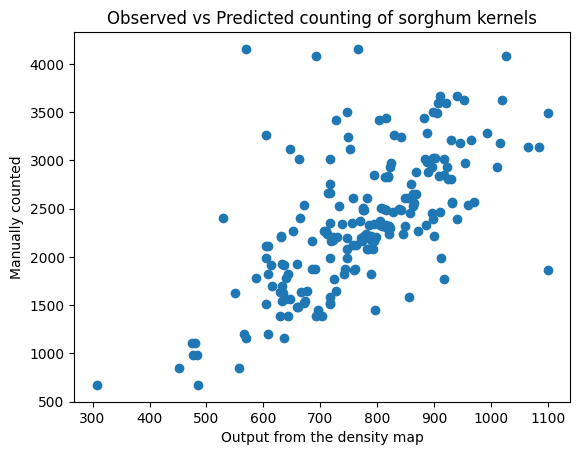

In [2]:
data = read_csv("estimated_counting.csv")

predicted = data['Predicted'].tolist()
observed = data['Observed'].tolist()

x = np.array(predicted).reshape((-1,1))
y = np.array(observed)

plt.scatter(x, y)
plt.title("Observed vs Predicted counting of sorghum kernels")
plt.xlabel("Output from the density map")
plt.ylabel("Manually counted")
plt.show()

### Making the Linear model

Coefficient of determination: 0.47580237313355844
Mean Square error: 365122.627407381
Roor Mean Square Error: 604.2537773215663
Mean Absolute Percentage Error (MAPE): 17.14753692707268 %
Model intercept: -1956.7975411366297, Model coefficients: [ 7.89630915e+00 -2.95335552e-03]


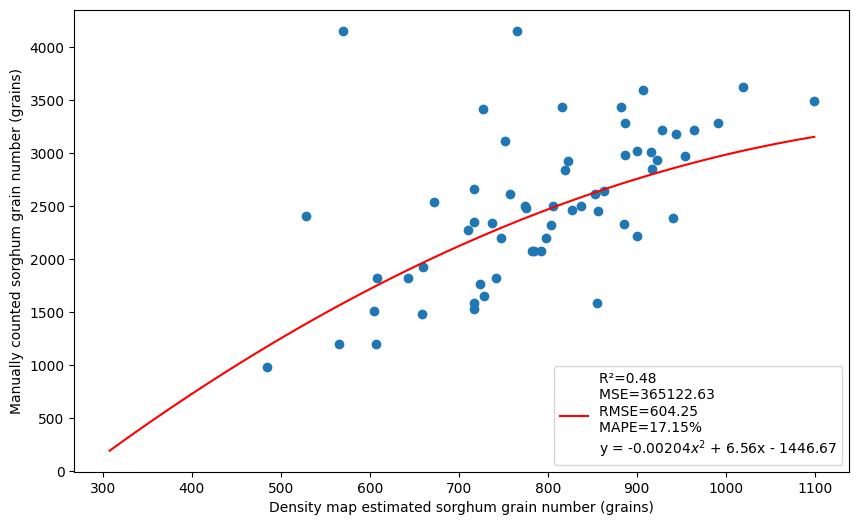

In [3]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

poly = PolynomialFeatures(degree=2)
x_ = poly.fit_transform(X_train)
model = LinearRegression().fit(x_, y_train)

x_test = poly.fit_transform(X_test)
y_pred = model.predict(x_test)

r_sq = model.score(x_, y_train)
mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mape = mean_absolute_percentage_error(y_test, y_pred)*100

print(f"Coefficient of determination: {r_sq}")
print(f"Mean Square error: {mse}")
print(f"Roor Mean Square Error: {rmse}")
print("Mean Absolute Percentage Error (MAPE):", mape, "%")
print(f"Model intercept: {model.intercept_}, Model coefficients: {model.coef_[1:]}")

# Plotting the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test)
# Plotting the regression line
x_range = np.linspace(min(x), max(x), 100).reshape((-1, 1))
x_range_poly = poly.transform(x_range)
y_range_pred = model.predict(x_range_poly)
plt.plot(x_range, y_range_pred, color='red',
         label=f'R²={r_sq:.2f} \nMSE={mse:.2f} \nRMSE={rmse:.2f} \nMAPE={mape:.2f}% \ny = -0.00204$x^2$ + 6.56x - 1446.67')
plt.xlabel("Density map estimated sorghum grain number (grains)")
plt.ylabel("Manually counted sorghum grain number (grains)")
plt.legend()
plt.savefig("Figure 5.pdf", format="pdf", bbox_inches="tight")
plt.show()